A notebook that contains evaluation timeseries and correlation plots that compare data from the ORCA buoy in hood canal to the model data. For now, it is only looking at 2007. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places, geo_tools
import gsw
import pickle
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
from matplotlib.colors import LogNorm
import Keegan_eval_tools as ket
#import scipy.io as so

In [3]:
choosepoint=False
if choosepoint==True:
    with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
        navlat=bathy.variables['nav_lat'][:,:]
        navlon=bathy.variables['nav_lon'][:,:]
    with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as mesh:
        tmask=mesh.variables['tmask'][0,:,:,:]
    indj,indi=geo_tools.find_closest_model_point(-123.93,49.75,navlon,navlat,land_mask=np.abs(tmask[0,:,:]-1))
    print(indj,indi)

    fig,ax=plt.subplots(1,1,figsize=(3,4))
    ax.pcolormesh(tmask[0,:,:])
    ax.plot(282,598,'r*')
    ax.set_ylim(550,700)
    ax.set_xlim(150,300)
    viz_tools.set_aspect(ax)

    fig,ax=plt.subplots(1,1,figsize=(3,2))
    ax.pcolormesh(tmask[:,598,:])
    ax.set_ylim(40,0)
    ax.plot(282,0,'r*')
    #ax.set_ylim(550,700)
    ax.set_xlim(150,300)
    #viz_tools.set_aspect(ax)
else:
    indj,indi=places.PLACES['Egmont']['NEMO grid ji']

In [4]:
year=2015
chlToN=1.8
indk=0
mooring='Twanoh'
saveloc='/ocean/kflanaga/MEOPAR/ORCAData'

In [5]:
datelims=(dt.datetime(2005,1,1),dt.datetime(2020,1,1))
start_date=datelims[0]
end_date=datelims[1]
Lon,Lat=places.PLACES[mooring]['lon lat']
citez=1.0

In [6]:
##### Loading in pickle file data
with open(os.path.join(saveloc,f'daily_data_{mooring}.pkl'),'rb') as hh:
    df0=pickle.load(hh)

In [7]:
ii,jj=geo_tools.get_ij_coordinates(Lat,Lon,
                                   grid_loc='/ocean/kflanaga/MEOPAR/grid/grid_from_lat_lon_mask999.nc')

In [8]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
start_date = df0['dtUTC'].iloc[0]
end_date = df0['dtUTC'].iloc[-1]+dt.timedelta(days=1)
flen=1
namfmt='nowcast'
filemap={'diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T',
         'vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}
df0['i']=ii
df0['j']=jj
df0['k']=3

In [9]:
# note: I only ran the first 365 data points to save time
df=et.matchData(df0.loc[(df0.dtUTC >= dt.datetime(2016,1,1))&(df0.dtUTC <= dt.datetime(2016,12,31))],filemap,fdict,start_date,end_date,namfmt,PATH,1,preIndexed=True);

In [10]:
df['mod_chl']=chlToN*(df['mod_diatoms']+df['mod_ciliates']+df['mod_flagellates'])
df['log_mod_chl']=ket.logt(df['mod_chl'])
df['log_chl']=ket.logt(df['Chl'])

/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
def quick_ts(obsvar,modvar):
    ps=[]
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    #Plotting the data
    p0,=ax.plot(df['dtUTC'],df[obsvar],'r.',label='Obs')
    ps.append(p0)
    p0,=ax.plot(df['dtUTC'],df[modvar],'c-',label='Mod')
    ps.append(p0)
    #altering the labels. 
    ax.set_xlabel(f'Date',fontsize=20)
    ax.set_ylabel(f'{obsvar}',fontsize=20)
    ax.set_title(str(2007), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    legend = plt.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    M = 11
    xticks = mpl.ticker.MaxNLocator(M)
    ax.xaxis.set_major_locator(xticks)
    plt.gca().add_artist(legend)
    yearsFmt = mdates.DateFormatter('%y %d %b')
    ax.xaxis.set_major_formatter(yearsFmt)
    return ps, ax

def quick_varvar(ax,df,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,df,obsvar,modvar)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps

# Chlorophyll

(0.0, 35.0)

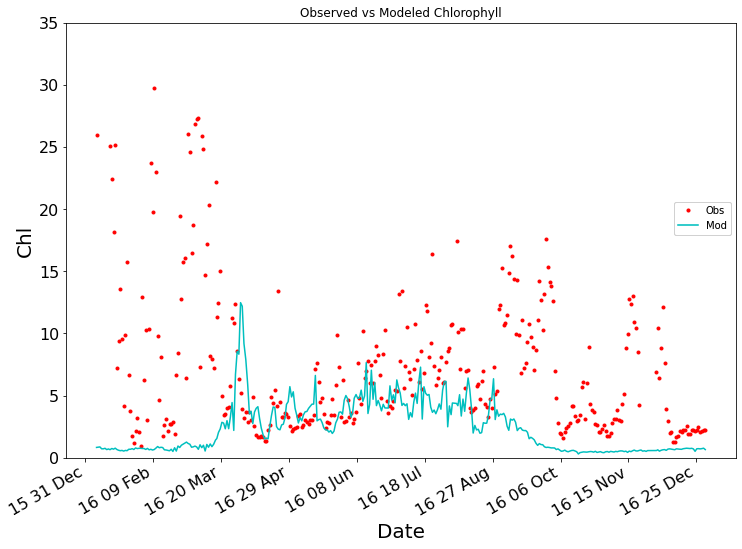

In [22]:
obsvar='Chl'
modvar='mod_chl'
ps,ax=quick_ts(obsvar,modvar)
ax.set_title('Observed vs Modeled Chlorophyll')
ax.set_ylim(0,35)

Text(0.5, 1.0, 'Observed vs model Chlorophyll')

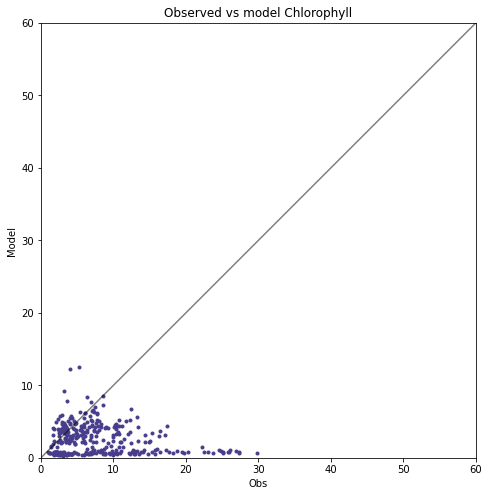

In [13]:
obsvar='Chl'
modvar='mod_chl'
lims=(0,60)
fig,ax=plt.subplots(1,1,figsize=(8,8))
ps=quick_varvar(ax,df,obsvar,modvar,lims)
ax.set_title('Observed vs model Chlorophyll')

# Log Transformed Chlorophyll 

Text(0.5, 1.0, 'Observed vs Modeled log10[Chlorophyll]')

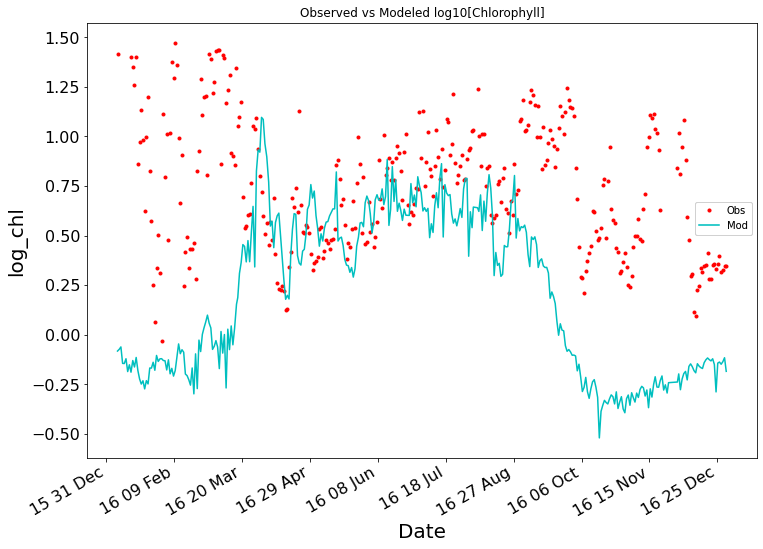

In [14]:
obsvar='log_chl'
modvar='log_mod_chl'
ps,ax=quick_ts(obsvar,modvar)
ax.set_title('Observed vs Modeled log10[Chlorophyll]')

(-2.0, 3.0)

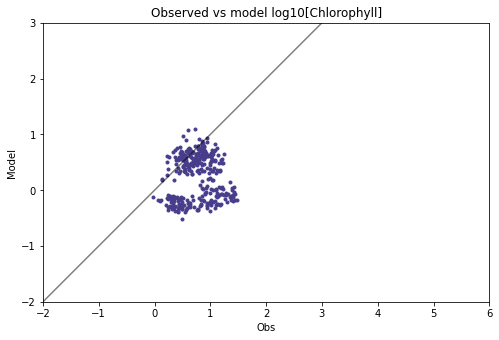

In [15]:
obsvar='log_chl'
modvar='log_mod_chl'
lims=(-2,6)
fig,ax=plt.subplots(1,1,figsize=(8,8))
ps=quick_varvar(ax,df,obsvar,modvar,lims)
ax.set_title('Observed vs model log10[Chlorophyll]')
ax.set_ylim(-2,3)

# Salinity

Text(0.5, 1.0, 'Observed vs Modeled Salinity')

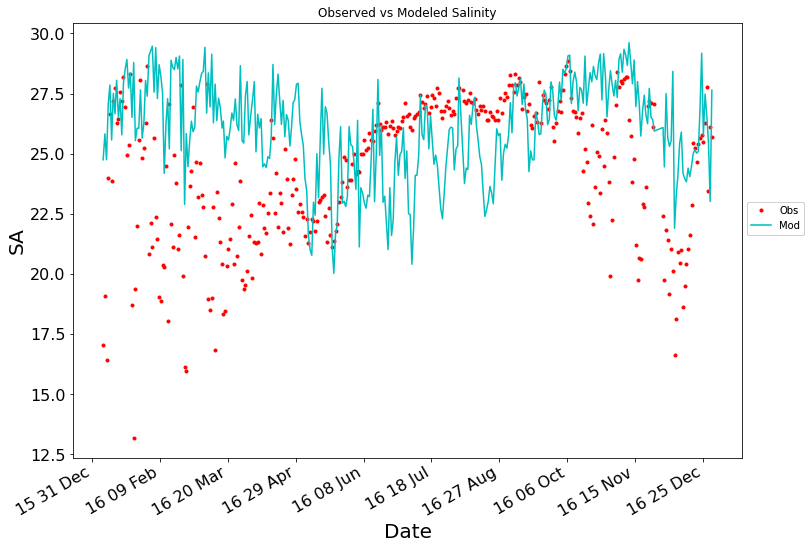

In [16]:
obsvar='SA'
modvar='mod_vosaline'
ps,ax=quick_ts(obsvar,modvar)
ax.set_title('Observed vs Modeled Salinity')

Text(0.5, 1.0, 'Observed vs model Salinity')

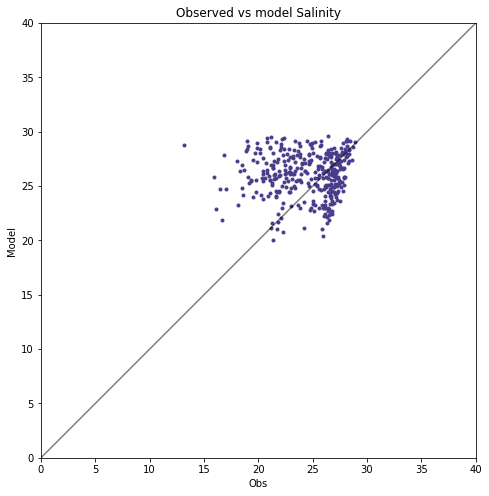

In [17]:
obsvar='SA'
modvar='mod_vosaline'
lims=(0,40)
fig,ax=plt.subplots(1,1,figsize=(8,8))
ps=quick_varvar(ax,df,obsvar,modvar,lims)
ax.set_title('Observed vs model Salinity')

# Temperature 

Text(0.5, 1.0, 'Observed vs Modeled Temperature')

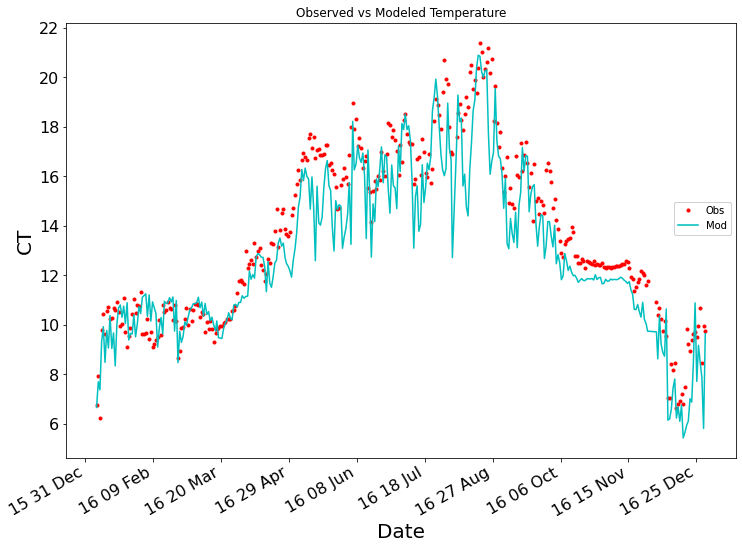

In [18]:
obsvar='CT'
modvar='mod_votemper'
ps,ax=quick_ts(obsvar,modvar)
ax.set_title('Observed vs Modeled Temperature')

Text(0.5, 1.0, 'Observed vs model Temperature')

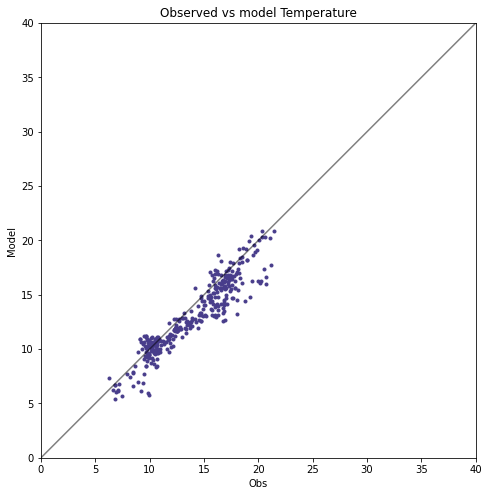

In [19]:
obsvar='CT'
modvar='mod_votemper'
lims=(0,40)
fig,ax=plt.subplots(1,1,figsize=(8,8))
ps=quick_varvar(ax,df,obsvar,modvar,lims)
ax.set_title('Observed vs model Temperature')